# Electricity DayAhead Prices in Poland

Importing modules

In [1]:
import datetime
from dateutil.parser import parse
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

Imputting end date

In [2]:
flag = True
while flag:
    dateEnd = input('Choose end date or leave empty to choose today. [dd-mm-yyy]')
    if dateEnd == '':
        dateEnd = datetime.datetime.today().strftime('%d-%m-%Y')
    try: 
        parse(dateEnd, fuzzy=False)
        dateEnd = datetime.datetime.strptime(dateEnd, '%d-%m-%Y')
        if dateEnd > datetime.datetime.today():
            print(dateEnd, 'is future date! Try again...')
            continue
        flag = False
    except ValueError:
        flag = True
        print('Invalid value. Try again...')

dateEnd = dateEnd - datetime.timedelta(days = 1)

Choose end date or leave empty to choose today. [dd-mm-yyy]


Imputting number of days

In [3]:
flag = True
while flag:
    sDays = input('Please input number of date (max 30 days)]')
    if sDays:
        try:
          iDays = int(sDays)
        
        except ValueError:
            print(sDays, 'is not an int number. Try again...')
            continue
        flag = False

Please input number of date (max 30 days)]20


Downloading DayAheadPrices to a dataframe

In [4]:
dfFix = pd.DataFrame(columns = ['Date' ,'Hour', 'Fix1_Price', 'Fix1_Vol', 'Fix2_Price', 'Fix2_Vol'])
dateStart = dateEnd - datetime.timedelta(days = iDays-1)
iDay = 0
for iDay in range(iDays):
    currDate = dateStart + datetime.timedelta(days = iDay)
    print('Downloading Day...', iDay+1)
    
    sFixTabURL = 'https://tge.pl/energia-elektryczna-rdn?dateShow=' + currDate.strftime('%d-%m-%Y') + '&dateAction='
    
    tgePage = requests.get(sFixTabURL)
    htmlDoc = tgePage.text
    soup = BeautifulSoup(htmlDoc, 'html.parser')
    table = soup.find(id = 'footable_kontrakty_godzinowe')
    bodyTable = table.tbody
    rowTable = bodyTable.tr
    
    deliveryDate = currDate + datetime.timedelta(days = 1)
    i=0
    for i in range(24):

        j=0
        cellTable = [deliveryDate]
        currElement = rowTable.td
    
        for j in range(5):

            cellTable.append(currElement.text.replace('\t','').replace('\n','').replace(',','.'))
            currElement = currElement.next_sibling.next_sibling
        
        dfFix.loc[len(dfFix)+1] = cellTable
        rowTable = rowTable.next_sibling.next_sibling

for index, row in dfFix.iterrows():
    if row['Fix1_Price']=='-' or row['Fix2_Price']=='-':
        
        dfFix.drop(index, inplace = True)

dfFix['Fix1_Price'] = dfFix['Fix1_Price'].astype(float)
dfFix['Fix1_Vol'] = dfFix['Fix1_Vol'].astype(float)
dfFix['Fix2_Price'] = dfFix['Fix2_Price'].astype(float)
dfFix['Fix2_Vol'] = dfFix['Fix2_Vol'].astype(float)

dfFix.describe()

,Fix1_Price,Fix1_Vol,Fix2_Price,Fix2_Vol
count,479.000000,479.000000,479.000000,479.000000
mean,636.166973,2821.730689,645.258497,1058.878914
std,220.841068,738.630503,221.589083,604.743246
min,299.360000,1457.300000,225.440000,215.100000
25%,479.790000,2251.000000,511.215000,530.550000
50%,611.270000,2731.000000,622.000000,907.600000
75%,700.000000,3235.150000,715.820000,1550.400000
max,1900.000000,5418.100000,1915.540000,3488.200000


In [5]:
pd.set_option('display.max_rows', 10)
dfFix

,Date,Hour,Fix1_Price,Fix1_Vol,Fix2_Price,Fix2_Vol
1,2022-03-14,0-1,433.89,2157.8,402.44,1168.6
2,2022-03-14,1-2,410.11,2281.7,406.87,1231.9
3,2022-03-14,2-3,410.11,2238.3,404.78,1234.6
4,2022-03-14,3-4,428.91,2181.4,408.54,1182.2
5,2022-03-14,4-5,482.74,1921.3,409.18,1148.3
...,...,...,...,...,...,...
476,2022-04-02,19-20,776.01,5061.1,850.09,2411.5
477,2022-04-02,20-21,790.67,5418.1,991.32,2670.7
478,2022-04-02,21-22,648.00,4886.2,677.29,2171.2
479,2022-04-02,22-23,600.00,4271.0,546.55,2094.0


Downloading Polish Power System's 5-year Plan

In [6]:
PSEdateStart = dateStart + datetime.timedelta(days = 1)
PSEdateEnd = dateEnd + datetime.timedelta(days = 1)

sDateStart = datetime.datetime.strftime(PSEdateStart,'%Y%m%d')
sDateEnd = datetime.datetime.strftime(PSEdateEnd,'%Y%m%d')
sURL_PSE = 'https://www.pse.pl/getcsv/-/export/csv/PL_PD_GO_BILANS/data_od/' + \
            sDateStart + '/data_do/' + sDateEnd
#print(sURL_PSE)

dfPSE5Y = pd.read_csv(sURL_PSE, encoding_errors = 'ignore', sep = ';')

In [7]:
pd.set_option('display.max_rows', 10)
dfPSE5Y

,Doba,Godzina,Prognozowane zapotrzebowanie sieci,Wymagana rezerwa mocy OSP,Nadwyka mocy dostpna dla OSP (7) + (9) - [(3) - (12)] - (13),Moc dyspozycyjna JW i magazynw energii wiadczcych usugi bilansujce w ramach RB,Moc dyspozycyjna JW i magazynw energii wiadczcych usugi bilansujce w ramach RB dostpna dla OSP,Przewidywana generacja JW i magazynw energii wiadczcych usugi bilansujce w ramach RB (3) - (9) - (12),Prognozowana generacja JW i magazynw energii nie wiadczcych usug bilansujcych w ramach RB,Prognozowana sumaryczna generacja rde wiatrowych,Prognozowana sumaryczna generacja rde fotowoltaicznych,Planowane saldo wymiany midzysystemowej,Prognozowana wielko niedyspozycyjnoci wynikajca z ogranicze sieciowych wystpujcych w sieci przesyowej oraz sieci dystrybucyjnej w zakresie dostarczania energii elektrycznej,Przewidywana generacja zasobw wytwrczych nieobjtych obowizkami mocowymi,Obowizki mocowe wszystkich jednostek rynku mocy
0,2022-03-14,1,15572,1619,4634,16053,13188,8553,8007,3903,0,-989,0,13897,0
1,2022-03-14,2,15084,1580,6085,16045,14361,8276,7748,3641,0,-940,0,13394,0
2,2022-03-14,3,14937,1555,6480,16036,14562,8082,7593,3489,0,-738,0,13161,0
3,2022-03-14,4,14954,1571,6212,16039,14565,8352,7479,3374,0,-877,0,13324,0
4,2022-03-14,5,15465,1649,5396,16037,14563,9168,7417,3313,0,-1119,0,14108,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,2022-04-02,20,19026,2047,3605,17839,16370,12765,8198,4434,7,-1937,0,18025,0
475,2022-04-02,21,19079,2065,3507,17825,16827,13319,7951,4106,0,-2191,0,17754,0
476,2022-04-02,22,17922,1923,4482,17461,16721,12239,7575,3776,0,-1892,0,16848,0
477,2022-04-02,23,16560,1782,4684,16523,15826,11142,7138,3414,0,-1721,0,15536,0


In [8]:
dfPSE5Y.describe()

,Godzina,Prognozowane zapotrzebowanie sieci,Wymagana rezerwa mocy OSP,Nadwyka mocy dostpna dla OSP (7) + (9) - [(3) - (12)] - (13),Moc dyspozycyjna JW i magazynw energii wiadczcych usugi bilansujce w ramach RB,Moc dyspozycyjna JW i magazynw energii wiadczcych usugi bilansujce w ramach RB dostpna dla OSP,Przewidywana generacja JW i magazynw energii wiadczcych usugi bilansujce w ramach RB (3) - (9) - (12),Prognozowana generacja JW i magazynw energii nie wiadczcych usug bilansujcych w ramach RB,Prognozowana sumaryczna generacja rde wiatrowych,Prognozowana sumaryczna generacja rde fotowoltaicznych,Planowane saldo wymiany midzysystemowej,Prognozowana wielko niedyspozycyjnoci wynikajca z ogranicze sieciowych wystpujcych w sieci przesyowej oraz sieci dystrybucyjnej w zakresie dostarczania energii elektrycznej,Przewidywana generacja zasobw wytwrczych nieobjtych obowizkami mocowymi,Obowizki mocowe wszystkich jednostek rynku mocy
count,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000
mean,12.475992,17907.837161,1927.430063,2938.908142,16820.772443,15435.098121,12477.736952,6311.826722,2217.870564,1134.972860,-881.772443,18.421712,9899.672234,11240.260960
std,6.916640,2295.584872,204.483846,970.872773,1491.222687,1873.207588,2407.336199,1531.976000,1568.813959,1490.641285,826.951065,74.029407,5763.729785,11955.674553
min,1.000000,12020.000000,1388.000000,1137.000000,12598.000000,11031.000000,6208.000000,3948.000000,67.000000,0.000000,-3614.000000,0.000000,1839.000000,0.000000
25%,6.500000,16359.500000,1790.500000,2234.500000,16329.500000,14118.000000,10771.500000,5051.500000,918.000000,0.000000,-1590.000000,0.000000,3552.500000,0.000000
50%,12.000000,17793.000000,1971.000000,2728.000000,17122.000000,15774.000000,12960.000000,5921.000000,1840.000000,104.000000,-805.000000,0.000000,11465.000000,0.000000
75%,18.000000,19494.500000,2089.500000,3468.500000,17770.500000,16743.500000,14125.000000,7200.500000,3193.000000,2346.000000,-104.000000,0.000000,15534.000000,23972.000000
max,24.000000,22494.000000,2382.000000,6480.000000,20008.000000,19370.000000,17400.000000,10387.000000,5928.000000,4724.000000,1058.000000,610.000000,18746.000000,23972.000000


Data cleaning

In [11]:
dfData = dfPSE5Y.copy(deep = True)

dfData.columns = ['Date', 'Hour', 'SysNeed', 'ReqCapRes', 'OvrCap', 'AvailCap', 'AvailCapPSO', 'GenBM', 'Gen_nBM', 
                     'Wind', 'PV', 'BlncIntrChng', 'GridUnavail', 'Gen_nCM', 'DutiesCM']

dfData['Date'] = pd.to_datetime(dfData['Date'])

weekdays = []
for i in range(len(dfData['Date'])):
    weekdays.append(dfData.iloc[i,0].weekday() + 1)

dfData.insert(0, "WeekDay", weekdays, True)
dfData.drop(labels = ['Date', 'DutiesCM'], axis = 1, inplace = True)

fixAv = []
for i in range(len(dfFix)):
    fix1 = dfFix.iloc[i,2]
    fix2 = dfFix.iloc[i,4]
    fix = (fix1 + fix2)/2
    fixAv.append(np.round(fix,2))

iPos = len(dfData.columns)
dfData.insert(iPos, "FixAvg", fixAv, True)

dfData.describe()

,WeekDay,Hour,SysNeed,ReqCapRes,OvrCap,AvailCap,AvailCapPSO,GenBM,Gen_nBM,Wind,PV,BlncIntrChng,GridUnavail,Gen_nCM,FixAvg
count,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000
mean,3.843424,12.475992,17907.837161,1927.430063,2938.908142,16820.772443,15435.098121,12477.736952,6311.826722,2217.870564,1134.972860,-881.772443,18.421712,9899.672234,640.712985
std,1.929325,6.916640,2295.584872,204.483846,970.872773,1491.222687,1873.207588,2407.336199,1531.976000,1568.813959,1490.641285,826.951065,74.029407,5763.729785,219.442029
min,1.000000,1.000000,12020.000000,1388.000000,1137.000000,12598.000000,11031.000000,6208.000000,3948.000000,67.000000,0.000000,-3614.000000,0.000000,1839.000000,262.400000
25%,2.000000,6.500000,16359.500000,1790.500000,2234.500000,16329.500000,14118.000000,10771.500000,5051.500000,918.000000,0.000000,-1590.000000,0.000000,3552.500000,502.210000
50%,4.000000,12.000000,17793.000000,1971.000000,2728.000000,17122.000000,15774.000000,12960.000000,5921.000000,1840.000000,104.000000,-805.000000,0.000000,11465.000000,615.820000
75%,5.000000,18.000000,19494.500000,2089.500000,3468.500000,17770.500000,16743.500000,14125.000000,7200.500000,3193.000000,2346.000000,-104.000000,0.000000,15534.000000,708.785000
max,7.000000,24.000000,22494.000000,2382.000000,6480.000000,20008.000000,19370.000000,17400.000000,10387.000000,5928.000000,4724.000000,1058.000000,610.000000,18746.000000,1907.770000


Looking for correlation

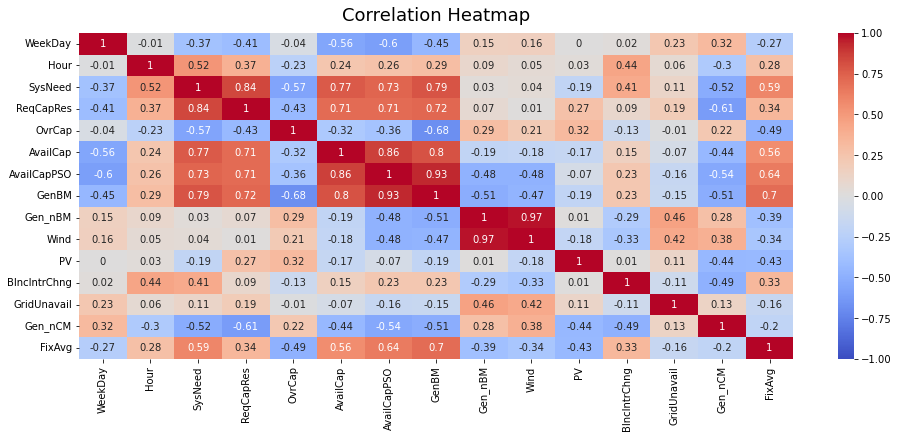

In [12]:
corrMatrix = np.round(dfData.corr(),2)

plt.figure(figsize=(16,6))
heatmap = sn.heatmap(corrMatrix, annot=True, cmap="coolwarm", center = 0, vmin = -1, vmax = 1)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
plt.show()

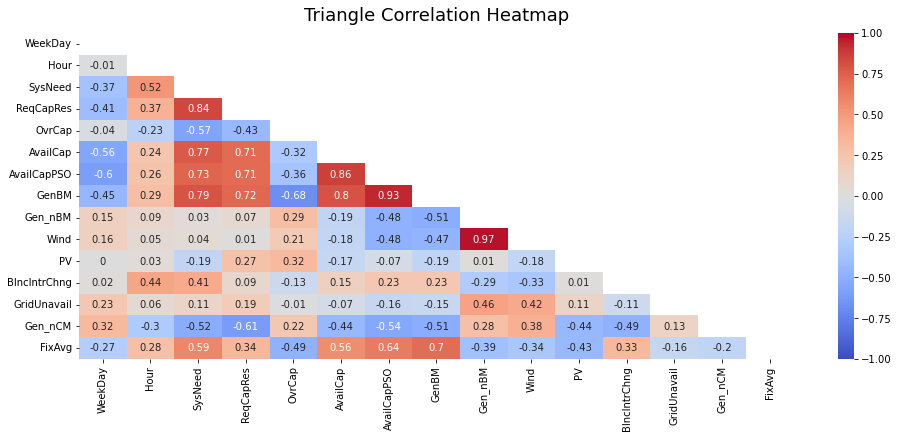

In [13]:
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
plt.figure(figsize=(16,6))
heatmap = sn.heatmap(corrMatrix, annot=True, cmap="coolwarm", center = 0, vmin = -1, vmax = 1, mask = mask)
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
plt.show()

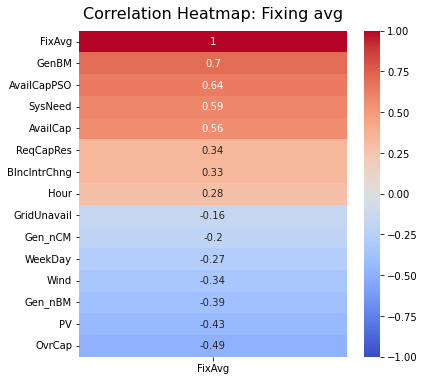

In [14]:
corrMatrixFix = corrMatrix[['FixAvg']].sort_values(by='FixAvg', ascending=False)
plt.figure(figsize=(6,6))
heatmap = sn.heatmap(corrMatrixFix, annot=True, cmap="coolwarm", center = 0, vmin = -1, vmax = 1)
heatmap.set_title('Correlation Heatmap: Fixing avg', fontdict={'fontsize':16}, pad=12)
plt.show()

In [ ]:
#Plotting interesting correlations

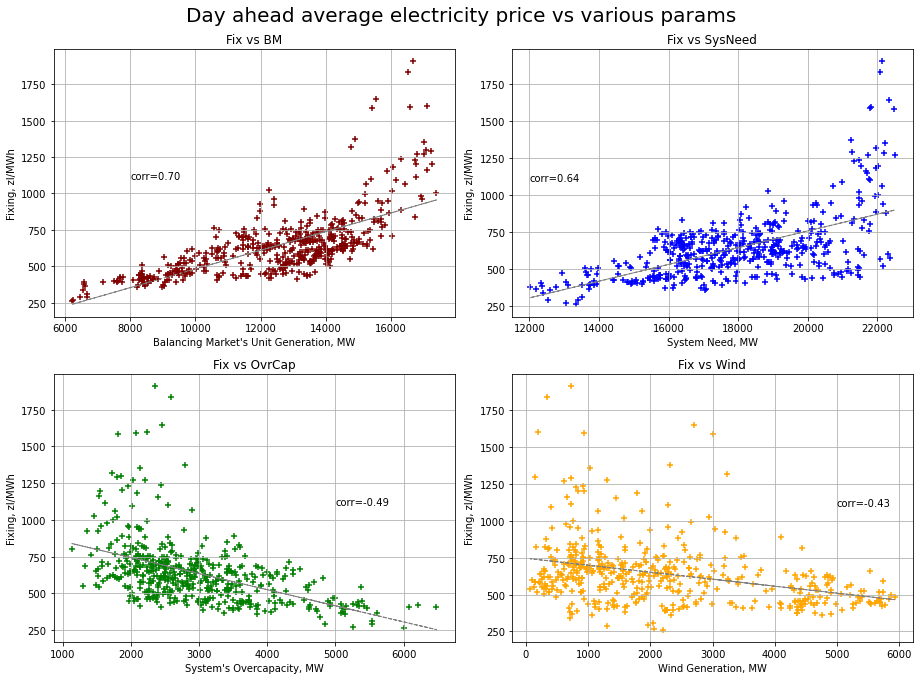

In [15]:
fig_1, axes = plt.subplots(2,2, figsize=(12.9,9.6))

axes[0][0].grid()
txt = 'corr=%.2f' % (corrMatrixFix.iloc[1])
axes[0][0].text(8000, 1100, txt , size=10)
axes[0][0].scatter(dfData['GenBM'],dfData['FixAvg'], color='maroon', marker='+')
axes[0][0].set_title('Fix vs BM')
axes[0][0].set_ylabel('Fixing, zl/MWh')
axes[0][0].set_xlabel('Balancing Market\'s Unit Generation, MW')

x,y = dfData['GenBM'], dfData['FixAvg']
z=np.polyfit(x,y,1)
p=np.poly1d(z)
axes[0][0].plot(x,p(x), color='grey', linewidth=1, linestyle='--')

axes[0][1].grid()
txt ='corr=%.2f' % (corrMatrixFix.iloc[2])
axes[0][1].text(12000, 1100, txt , size=10)
axes[0][1].scatter(dfData['SysNeed'],dfData['FixAvg'], color='blue', marker='+')
axes[0][1].set_title('Fix vs SysNeed')
axes[0][1].set_ylabel('Fixing, zl/MWh')
axes[0][1].set_xlabel('System Need, MW')

x,y = dfData['SysNeed'], dfData['FixAvg']
z=np.polyfit(x,y,1)
p=np.poly1d(z)
axes[0][1].plot(x,p(x), color='grey', linewidth=1, linestyle='--')

axes[1][0].grid()
txt ='corr=%.2f' % (corrMatrixFix.iloc[-1])
axes[1][0].text(5000, 1100, txt , size=10)
axes[1][0].scatter(dfData['OvrCap'],dfData['FixAvg'], color='green', marker='+')
axes[1][0].set_title('Fix vs OvrCap')
axes[1][0].set_ylabel('Fixing, zl/MWh')
axes[1][0].set_xlabel('System\'s Overcapacity, MW')

x,y = dfData['OvrCap'], dfData['FixAvg']
z=np.polyfit(x,y,1)
p=np.poly1d(z)
axes[1][0].plot(x,p(x), color='grey', linewidth=1, linestyle='--')

axes[1][1].grid()
txt ='corr=%.2f' % (corrMatrixFix.iloc[-2])
axes[1][1].text(5000, 1100, txt , size=10)
axes[1][1].scatter(dfData['Wind'],dfData['FixAvg'], color='orange', marker='+')
axes[1][1].set_title('Fix vs Wind')
axes[1][1].set_ylabel('Fixing, zl/MWh')
axes[1][1].set_xlabel('Wind Generation, MW')

x,y = dfData['Wind'], dfData['FixAvg']
z=np.polyfit(x,y,1)
p=np.poly1d(z)
axes[1][1].plot(x,p(x), color='grey', linewidth=1, linestyle='--')

fig_1.suptitle('Day ahead average electricity price vs various params', fontsize = 20)
fig_1.tight_layout()
plt.show()

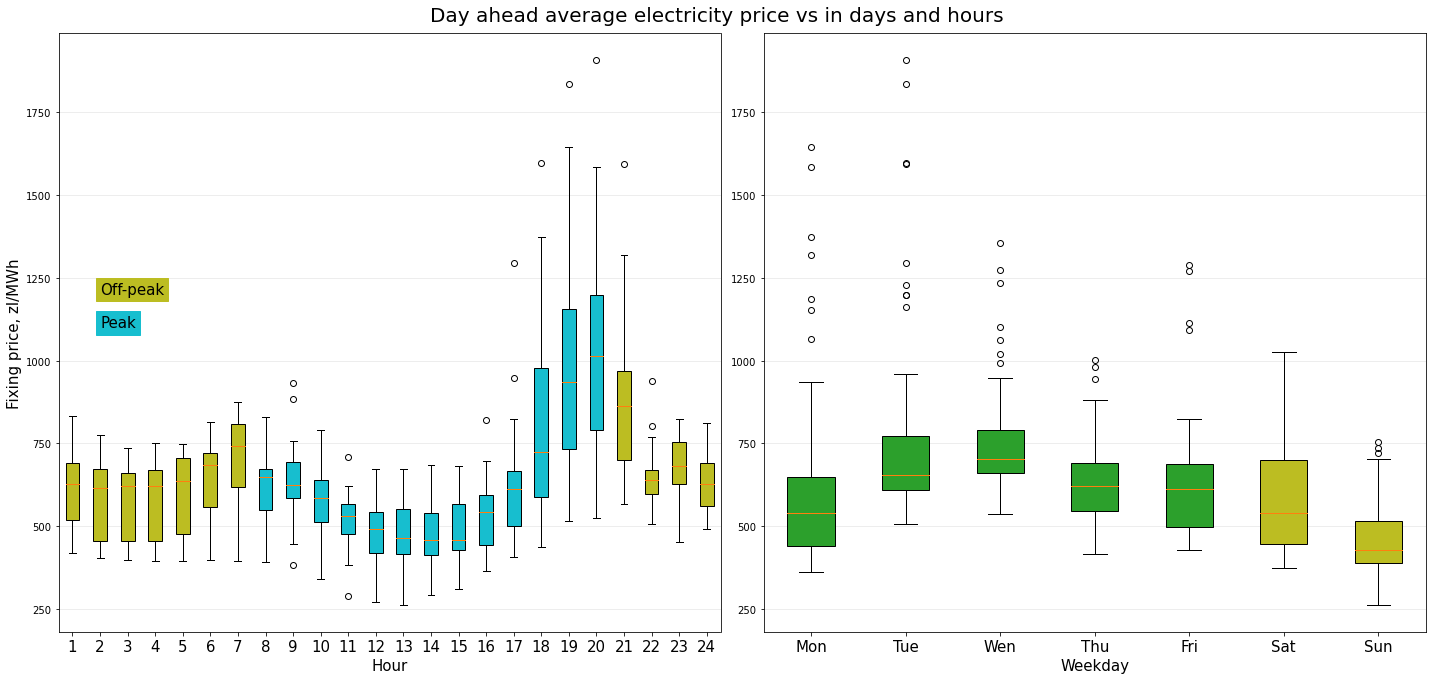

In [16]:
bp_data1 = []
for iH in range(1,25):
    bp_data1.append(dfData.loc[dfData['Hour']==iH,'FixAvg'])

bp_data2 = []
for iD in range(1,8):
    bp_data2.append(dfData.loc[dfData['WeekDay']==iD,'FixAvg'])

fig_2, (ax1, ax2) = plt.subplots(1,2, figsize=(20,9.6))

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
bplot1=ax1.boxplot(bp_data1, patch_artist=True)
ax1.set_xlabel('Hour', fontsize = 15)
ax1.set_ylabel('Fixing price, zl/MWh', fontsize = 15)
ax1.xaxis.set_tick_params(labelsize=15)

txt=['Off-peak', 'Peak']
ax1.text(2,1200, txt[0], size=15, backgroundcolor='C8')
ax1.text(2,1100, txt[1], size=15, backgroundcolor='C9')

ax2.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
bplot2 = ax2.boxplot(bp_data2, patch_artist=True)
ax2.set_xticklabels(['Mon','Tue','Wen','Thu','Fri','Sat','Sun'], fontsize = 15)
ax2.set_xlabel('Weekday', fontsize = 15)

i=1
for box in bplot1['boxes']:
    if 7<i<21:
        box.set(facecolor='C9')
    else:
        box.set(facecolor='C8')
    i+=1

i=1
for box in bplot2['boxes']:
    if i<6:
        box.set(facecolor='C2')
    else:
        box.set(facecolor='C8')
    i+=1



fig_2.suptitle('Day ahead average electricity price vs in days and hours', fontsize = 20)
fig_2.tight_layout()
plt.show()

In [18]:
WeekDays=[]
for index ,row in dfFix.iterrows():
    WeekDays.append(datetime.date.weekday(row['Date']))
dfFix['WeekDay']=WeekDays

Hours=[]
for index ,row in dfFix.iterrows():
    iPos = row['Hour'].find('-')
    iH=int(row['Hour'][:iPos])+1
    Hours.append(iH)
dfFix['Hour']=Hours

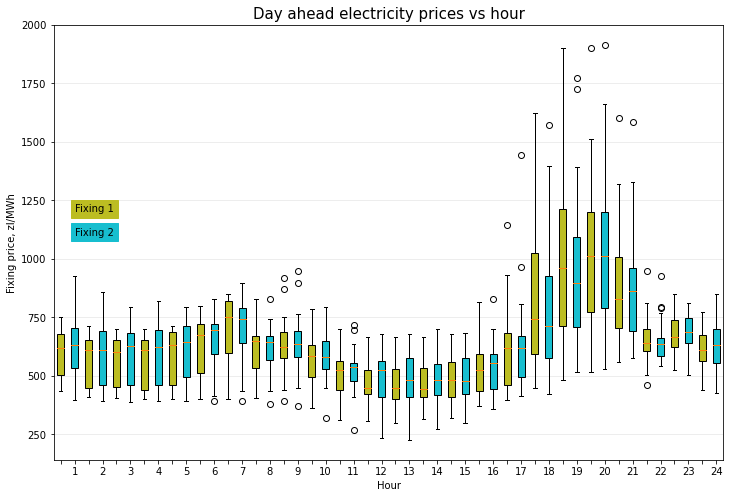

In [23]:
bp_data3 = []
for iH in range(1,25):
    bp_data3.append(dfFix.loc[(dfFix['Hour']==iH),'Fix1_Price'])
    bp_data3.append(dfFix.loc[(dfFix['Hour']==iH),'Fix2_Price'])

fig, ax = plt.subplots(1,1, figsize=(12,8))
bplot1 = ax.boxplot(bp_data3, patch_artist=True)

i=1
for box in bplot1['boxes']:
    if i%2==0:
        box.set(facecolor='C9')
    else:
        box.set(facecolor='C8')
    i+=1

ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
ax.set_xlabel('Hour')
ax.set_ylabel('Fixing price, zl/MWh')
ax.set_title('Day ahead electricity prices vs hour', size=15)

txt=['Fixing 1', 'Fixing 2']
ax.text(2,1200, txt[0], size=10, backgroundcolor='C8')
ax.text(2,1100, txt[1], size=10, backgroundcolor='C9')

x_labs=[]
for i in range(1,49):
    if i%2==0:
        x_labs.append(int(i/2))
    else:
        x_labs.append('')

ax.set_xticklabels(x_labs)
plt.show()

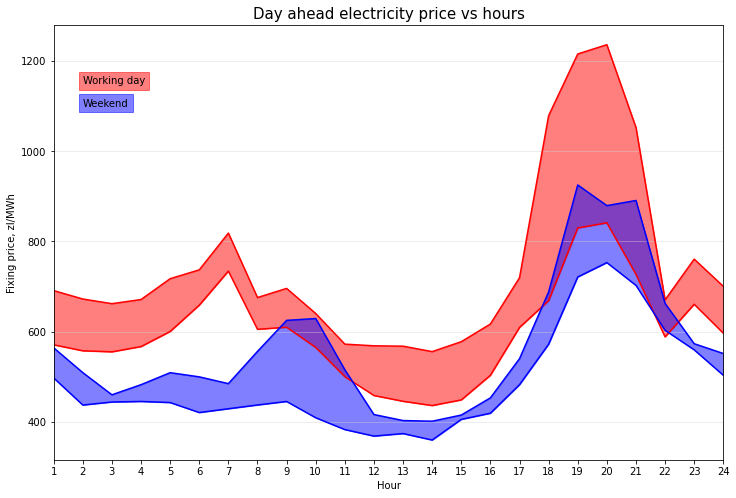

In [24]:
Y1 = dfData.loc[dfData['WeekDay']<6].groupby('Hour').quantile(q=.25)['FixAvg']
Y2 = dfData.loc[dfData['WeekDay']<6].groupby('Hour').quantile(q=.75)['FixAvg']

Y3 = dfData.loc[dfData['WeekDay']>5].groupby('Hour').quantile(q=.25)['FixAvg']
Y4 = dfData.loc[dfData['WeekDay']>5].groupby('Hour').quantile(q=.75)['FixAvg']

X = np.arange(1,25)

fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

L1 = ax.plot(X,Y1, color='red')
L2 = ax.plot(X,Y2, color='red')

L3 = ax.plot(X,Y3, color='blue')
L4 = ax.plot(X,Y4, color='blue')

A1 = ax.fill_between(X, Y1, Y2, color='red', alpha = .5)
A2 = ax.fill_between(X, Y3, Y4, color='blue', alpha = .5)

ax.set_xlabel('Hour')
ax.set_ylabel('Fixing price, zl/MWh')
ax.set_title('Day ahead electricity price vs hours', size=15)
ax.set_xticks(X)
ax.set_xlim(1,max(X))

txt=['Working day', 'Weekend']
ax.text(2,1100, txt[1], size=10, backgroundcolor=(0,0,1,0.5))
ax.text(2,1150, txt[0], size=10, backgroundcolor=(1,0,0,0.5))

plt.show()